# EEG Signal Processing - Step-by-Step Educational Guide

Learn professional EEG preprocessing with reusable code.

## What You'll Learn
1. Why preprocessing matters
2. Highpass → Lowpass → Notch filtering
3. Frequency band analysis
4. Reusable functions for your projects

## Quick Start
- Change `CSV_FILE`, `SAMPLING_RATE`, `CHANNEL_NAME` in Step 1
- Run all cells
- Copy functions for your own projects

## Step 1: Configuration

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 🔧 CHANGE THESE FOR YOUR DATA
CSV_FILE = 'ChordsWeb-20251111-193931.csv'
CHANNEL_NAME = 'Channel1'
SAMPLING_RATE = 500.0  # Hz
# WHY 500 Hz? 
#   - Nyquist theorem requires 2x highest frequency
#   - Brain signals go up to ~100 Hz (gamma)
#   - 500 Hz captures up to 250 Hz cleanly
#   - Standard in research EEG (clinical: 256 Hz, research: 500-1000 Hz)
CONVERSION_FACTOR = 1000.0  # Multiply to get µV

# Preprocessing parameters
HIGHPASS_CUTOFF = 4.0  # Hz
# WHY 4 Hz?
#   - Removes slow drifts and DC offset
#   - Preserves theta (4-8 Hz) and above
#   - Trade-off: loses delta band (0.5-4 Hz)
#   - Chosen because we focus on theta/alpha/beta/gamma
LOWPASS_CUTOFF = 45.0  # Hz
# WHY 45 Hz?
#   - Keeps full gamma band (30-45 Hz)
#   - Removes muscle artifacts (>50 Hz)
#   - Stays below line noise (50 Hz)
#   - Muscle EMG is typically 50-200 Hz
NOTCH_FREQ = 50.0  # Hz (50 Europe/Asia, 60 Americas)
# WHY 50 Hz?
#   - Electrical line noise from AC power
#   - 50 Hz in Europe/Asia/Africa/Australia
#   - 60 Hz in Americas
#   - Pure artifact, not brain activity (50 Europe/Asia, 60 Americas)
FILTER_ORDER = 4
# WHY Order 4?
#   - Higher order = sharper cutoff, more ringing
#   - Lower order = gentler cutoff, less distortion
#   - Order 4 = good compromise (24 dB/octave)
#   - Standard in EEG research

# Frequency bands
BANDS = {
    # WHY these specific frequency ranges?
    # These are universally accepted ranges based on decades of research
    # Each band correlates with specific mental states and brain functions
    'delta': (0.5, 4.0),
    'theta': (4.0, 8.0),
    'alpha': (8.0, 13.0),
    'beta': (13.0, 30.0),
    'gamma': (30.0, 45.0)
}

print(f"✓ Config loaded: {SAMPLING_RATE} Hz, {HIGHPASS_CUTOFF}-{LOWPASS_CUTOFF} Hz")

✓ Config loaded: 500.0 Hz, 4.0-45.0 Hz


### Why These Configuration Choices?

**Sampling Rate (500 Hz)**
- Nyquist theorem requires sampling at 2× highest frequency
- Brain signals: Delta (0.5-4 Hz), Theta (4-8 Hz), Alpha (8-13 Hz), Beta (13-30 Hz), Gamma (30-100 Hz)
- 500 Hz captures up to 250 Hz cleanly (well above gamma)
- Trade-off: Higher = better quality but larger files

**High-Pass Filter (4 Hz)**
- Removes: Slow drifts, DC offset, movement artifacts
- Keeps: Theta, Alpha, Beta, Gamma bands
- Trade-off: Loses Delta band (0.5-4 Hz)
- Choice: We prioritize clean signal over delta information

**Low-Pass Filter (45 Hz)**
- Removes: Muscle artifacts (EMG > 50 Hz), high-frequency noise
- Keeps: All brain waves including full gamma band
- Trade-off: More permissive = more noise, more restrictive = lose gamma
- Choice: 45 Hz preserves gamma while removing most artifacts

**Notch Filter (50 Hz)**
- Removes: Electrical line noise from AC power
- Narrow bandwidth (~1.67 Hz) minimizes impact on nearby frequencies
- Essential: This noise is NOT brain activity
- Regional: 50 Hz (Europe/Asia), 60 Hz (Americas)


## Step 2: Load Data

In [34]:
df = pd.read_csv(CSV_FILE)
eeg_raw = df[CHANNEL_NAME].values * CONVERSION_FACTOR
# WHY .values? Converts pandas Series to numpy array for faster processing
# WHY multiply? Raw data in mV, we need ?V (standard EEG unit)
time = np.arange(len(eeg_raw)) / SAMPLING_RATE
# WHY divide by sampling rate? Converts sample numbers to seconds
# Example: sample 500 at 500 Hz = 1.0 second

print(f"✓ Loaded {len(eeg_raw):,} samples ({len(eeg_raw)/SAMPLING_RATE:.1f}s)")
print(f"  Range: {eeg_raw.min():.1f} to {eeg_raw.max():.1f} µV")
print(f"  Mean: {eeg_raw.mean():.1f} µV, Std: {eeg_raw.std():.1f} µV")

✓ Loaded 262,000 samples (524.0s)
  Range: -68.3 to 64.1 µV
  Mean: 0.0 µV, Std: 2.8 µV


## Step 3: Visualize Raw Signal


📊 Creating visualization...



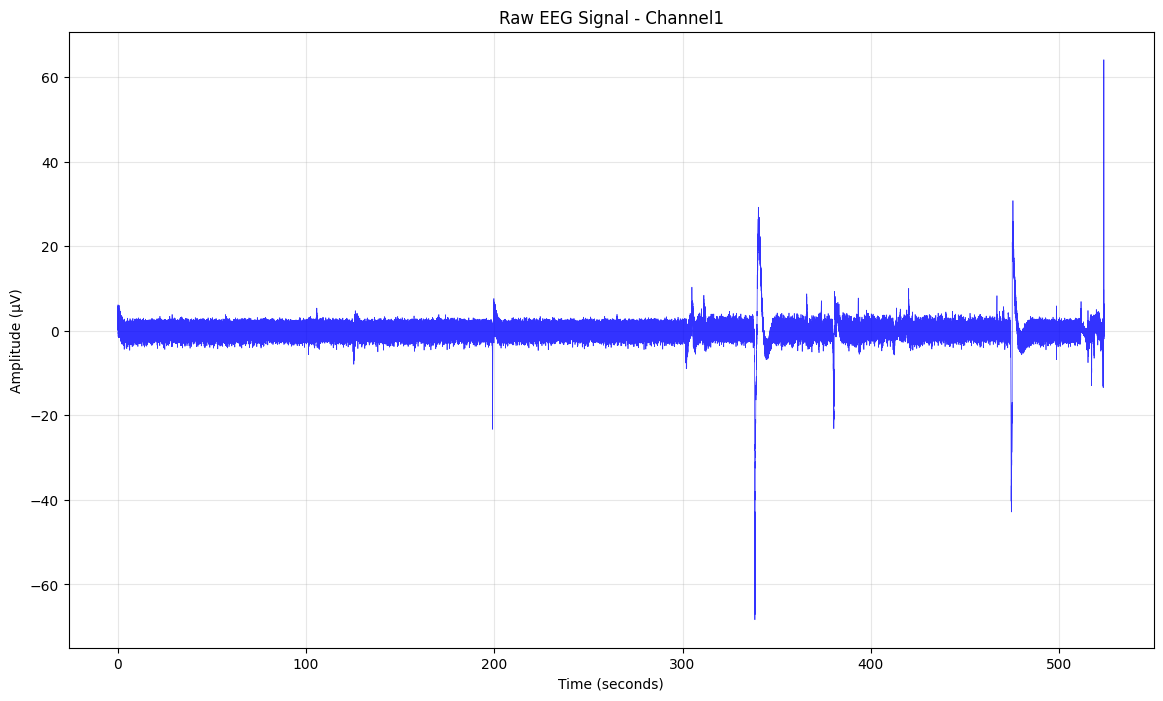

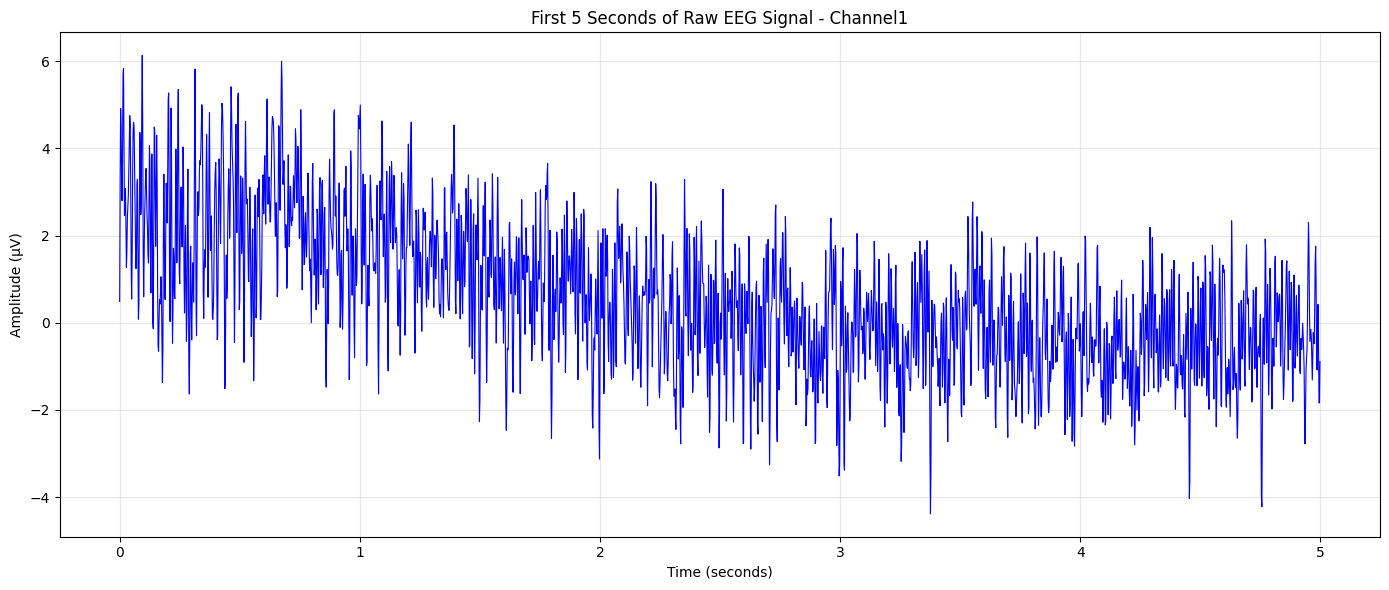

✅ Visualization complete!


In [37]:
# ============================================
# SECTION: Visualize EEG Signals
# ============================================
# Plot the EEG data to see the signal quality

# Create a figure with appropriate size
plt.figure(figsize=(14, 8))

# Plot the EEG channel
# This helps us see:
# - Signal quality
# - Presence of artifacts
# - Overall amplitude and patterns

plt.plot(time, eeg_raw, linewidth=0.5, color='blue', alpha=0.8)

# Add labels and title for clarity
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (µV)')
plt.title(f'Raw EEG Signal - {CHANNEL_NAME}')
plt.grid(True, alpha=0.3)


# Optional: Plot a smaller segment to see details
plt.figure(figsize=(14, 6))

# Plot first 5 seconds of data
samples_to_plot = int(5 * SAMPLING_RATE)
plt.plot(time[:samples_to_plot], eeg_raw[:samples_to_plot], linewidth=0.8, color='blue')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (µV)')
plt.title(f'First 5 Seconds of Raw EEG Signal - {CHANNEL_NAME}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

## Step 4: Reusable Filter Functions
**Copy these for your projects!**

In [26]:
def highpass_filter(data, cutoff, fs, order=4):
    """Remove DC drift and slow artifacts."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='high')
    return signal.filtfilt(b, a, data)

def lowpass_filter(data, cutoff, fs, order=4):
    """Remove high-frequency noise."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low')
    return signal.filtfilt(b, a, data)

def notch_filter(data, freq, fs, quality=30):
    """Remove power line interference."""
    b, a = signal.iirnotch(  # WHY IIR not FIR?
    # IIR (Infinite Impulse Response) more efficient for notch
    # Requires fewer coefficients
    # Sharp notch with minimal computationfreq, quality, fs)
    return signal.filtfilt(b, a, data)

def preprocess_eeg(data, fs, highpass=4.0, lowpass=45.0, notch=50.0, order=4):
    """Complete EEG preprocessing pipeline."""
    filtered = highpass_filter(data, highpass, fs, order)
    filtered = lowpass_filter(filtered, lowpass, fs, order)
    filtered = notch_filter(filtered, notch, fs)
    return filtered

print("✓ Filter functions defined")

✓ Filter functions defined


## Step 5: Apply Preprocessing

In [27]:
print("Applying preprocessing...")
eeg_preprocessed = preprocess_eeg(eeg_raw, SAMPLING_RATE, HIGHPASS_CUTOFF, LOWPASS_CUTOFF, NOTCH_FREQ, FILTER_ORDER)

print(f"✓ Complete!")
print(f"  Raw std: {eeg_raw.std():.1f} µV")
print(f"  Preprocessed std: {eeg_preprocessed.std():.1f} µV")
print(f"  Noise reduction: {(1 - eeg_preprocessed.std()/eeg_raw.std())*100:.1f}%")

Applying preprocessing...
✓ Complete!
  Raw std: 2.8 µV
  Preprocessed std: 0.7 µV
  Noise reduction: 73.9%


## Step 6: Compare Raw vs Preprocessed

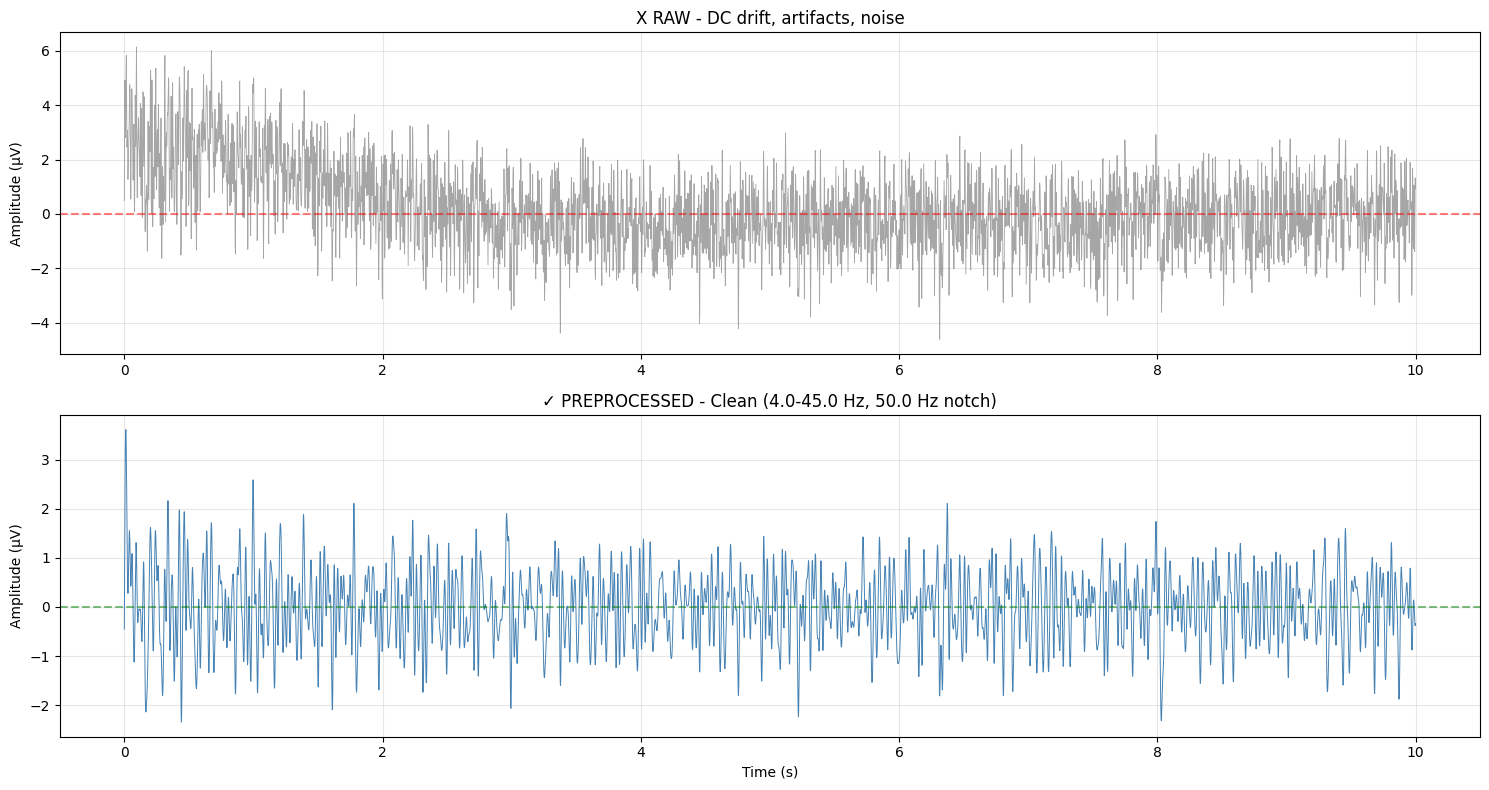

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Option 1: Use text symbols instead of emojis
ax1.plot(time[:5000], eeg_raw[:5000], linewidth=0.6, color='gray', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_ylabel('Amplitude (µV)')
ax1.set_title('X RAW - DC drift, artifacts, noise')  # Changed from ❌ to X
ax1.grid(True, alpha=0.3)

ax2.plot(time[:5000], eeg_preprocessed[:5000], linewidth=0.7, color='steelblue')
ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (µV)')
ax2.set_title(f'✓ PREPROCESSED - Clean ({HIGHPASS_CUTOFF}-{LOWPASS_CUTOFF} Hz, {NOTCH_FREQ} Hz notch)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Power Spectral Density

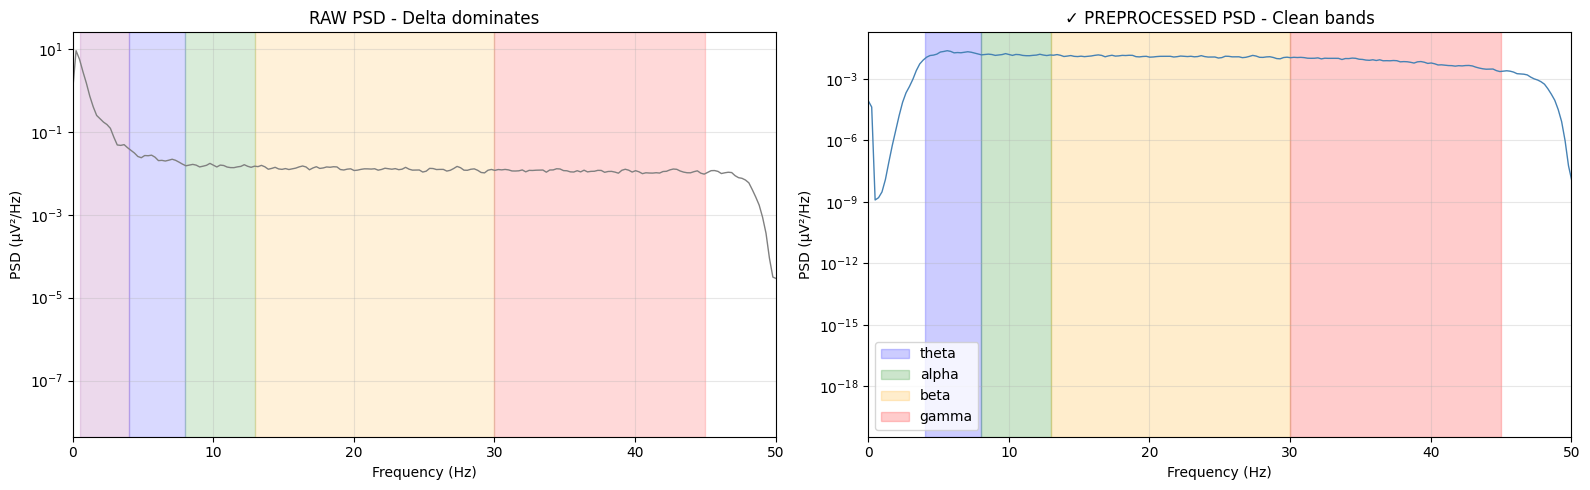

Delta (0.5-4 Hz) excluded: contaminated by artifacts


In [29]:
freqs_raw, psd_raw = signal.welch(eeg_raw, fs=SAMPLING_RATE, nperseg=2048)
freqs_clean, psd_clean = signal.welch(eeg_preprocessed, fs=SAMPLING_RATE, nperseg=2048)

colors = {'delta': 'purple', 'theta': 'blue', 'alpha': 'green', 'beta': 'orange', 'gamma': 'red'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.semilogy(freqs_raw, psd_raw, linewidth=1, color='gray')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('PSD (µV²/Hz)')
ax1.set_title('RAW PSD - Delta dominates')
ax1.set_xlim(0, 50)
ax1.grid(True, alpha=0.3)
for band, (low, high) in BANDS.items():
    ax1.axvspan(low, high, alpha=0.15, color=colors[band])

ax2.semilogy(freqs_clean, psd_clean, linewidth=1, color='steelblue')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD (µV²/Hz)')
ax2.set_title('✓ PREPROCESSED PSD - Clean bands')
ax2.set_xlim(0, 50)
ax2.grid(True, alpha=0.3)
for band, (low, high) in BANDS.items():
    if band != 'delta':
        ax2.axvspan(low, high, alpha=0.2, color=colors[band], label=band)
ax2.legend()

plt.tight_layout()
plt.show()

print("Delta (0.5-4 Hz) excluded: contaminated by artifacts")

## Step 8: Band Power Analysis
**Reusable function:**

In [30]:
def calculate_band_power(data, fs, band, nperseg=2048):
    """Calculate power in frequency band."""
    lowcut, highcut = band
    freqs, psd = signal.welch(data, fs=fs, nperseg=nperseg)
    idx = np.logical_and(freqs >= lowcut, freqs <= highcut)
    return np.trapz(psd[idx], freqs[idx])

def analyze_bands(data, fs, bands, exclude_delta=True):
    """Calculate all band powers and percentages."""
    powers = {}
    for name, band_range in bands.items():
        if exclude_delta and name == 'delta':
            continue
        powers[name] = calculate_band_power(data, fs, band_range)
    
    total = sum(powers.values())
    percentages = {name: (power / total) * 100 for name, power in powers.items()}
    return powers, percentages

print("✓ Band power functions defined")

✓ Band power functions defined


## Step 9: Calculate Band Powers

In [31]:
powers, percentages = analyze_bands(eeg_preprocessed, SAMPLING_RATE, BANDS, exclude_delta=True)

print("="*50)
print("✓ PREPROCESSED DATA - Band Powers (Delta excluded)")
print("="*50)
for band in ['theta', 'alpha', 'beta', 'gamma']:
    print(f"{band.capitalize():8s}: {powers[band]:10.2f} µV²  ({percentages[band]:5.1f}%)")
print(f"\nTotal:     {sum(powers.values()):10.2f} µV²")

dominant = max(percentages, key=percentages.get)
print(f"\nDominant band: {dominant.capitalize()} ({percentages[dominant]:.1f}%)")

✓ PREPROCESSED DATA - Band Powers (Delta excluded)
Theta   :       0.07 µV²  ( 15.1%)
Alpha   :       0.07 µV²  ( 15.9%)
Beta    :       0.21 µV²  ( 45.4%)
Gamma   :       0.11 µV²  ( 23.6%)

Total:           0.46 µV²

Dominant band: Beta (45.4%)


## Step 10: Visualize Band Powers

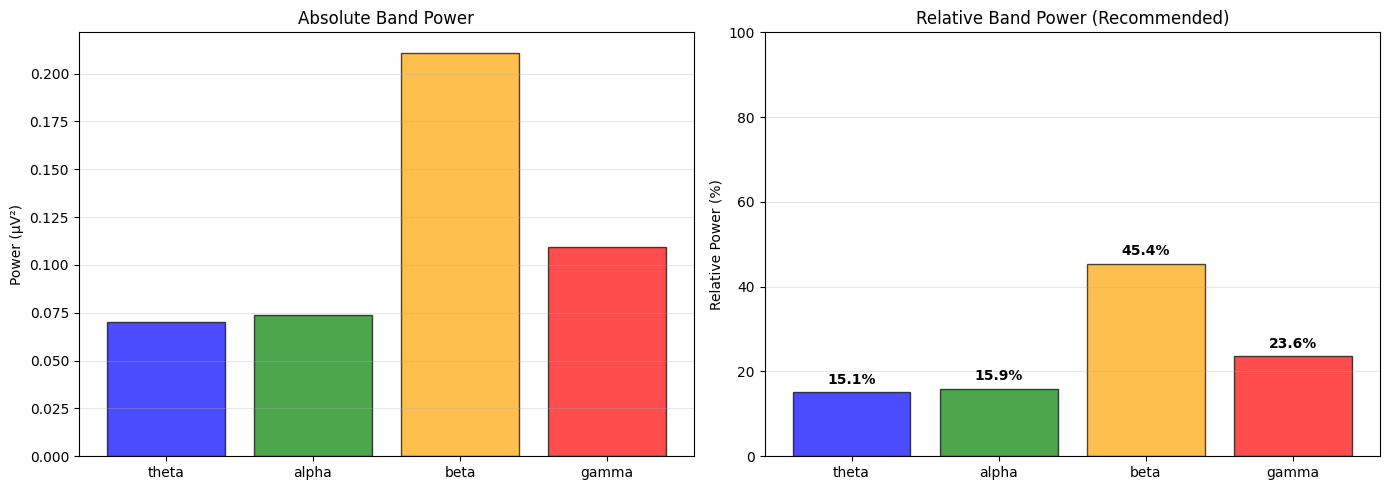

In [17]:
bands = list(powers.keys())
power_vals = list(powers.values())
pct_vals = list(percentages.values())
colors_list = [colors[b] for b in bands]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(bands, power_vals, color=colors_list, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Power (µV²)')
ax1.set_title('Absolute Band Power')
ax1.grid(True, alpha=0.3, axis='y')

ax2.bar(bands, pct_vals, color=colors_list, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Relative Power (%)')
ax2.set_title('Relative Band Power (Recommended)')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 100)

for i, pct in enumerate(pct_vals):
    ax2.text(i, pct + 2, f'{pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Practice Exercise 1: Alpha Wave Detection

**Goal:** Extract and analyze alpha waves (8-13 Hz) - the "relaxation rhythm"

**Background:** Alpha waves appear when you're relaxed with eyes closed. Strong alpha = relaxed state.

**Your Task:** Extract alpha band and calculate its power


🧠 Alpha Wave Analysis
Alpha Power: 0.08 µV²
Alpha RMS: 0.29 µV


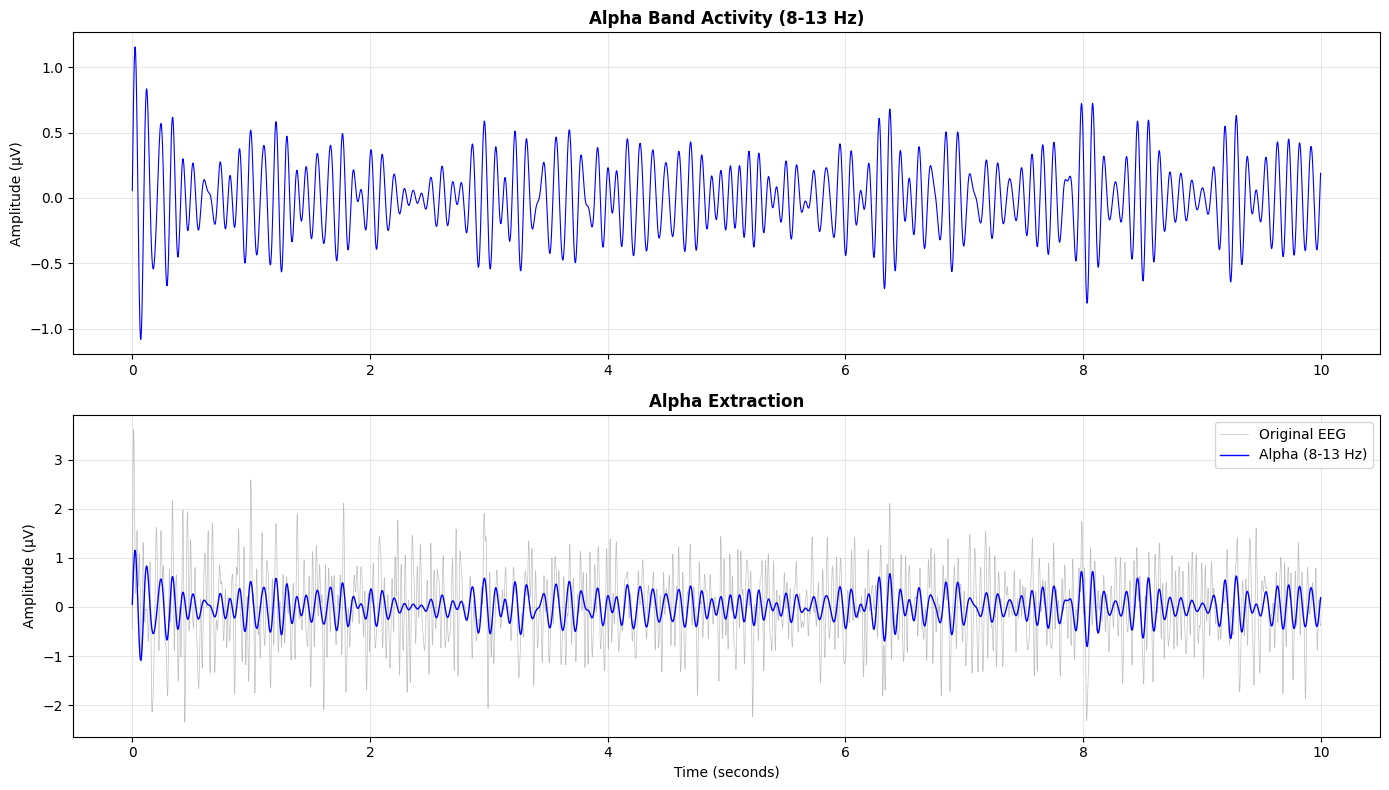


💡 Interpretation:
  - Higher alpha power = more relaxed
  - Typical alpha: 9-11 Hz in adults
  - Try: Compare eyes open vs eyes closed!


In [28]:
from scipy.signal import butter, filtfilt

# Reusable bandpass filter function
def bandpass_filter(data, low_freq, high_freq, fs, order=4):
    """Extract specific frequency band."""
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Extract alpha band (8-13 Hz)
alpha_signal = bandpass_filter(eeg_preprocessed, 8.0, 13.0, SAMPLING_RATE)

# Calculate alpha power
alpha_power = np.mean(alpha_signal ** 2)

print(f"\n🧠 Alpha Wave Analysis")
print(f"Alpha Power: {alpha_power:.2f} µV²")
print(f"Alpha RMS: {np.sqrt(alpha_power):.2f} µV")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot alpha signal (first 10 seconds)
plot_duration = 10
plot_samples = int(plot_duration * SAMPLING_RATE)
axes[0].plot(time[:plot_samples], alpha_signal[:plot_samples], 'b-', linewidth=0.8)
axes[0].set_title('Alpha Band Activity (8-13 Hz)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude (µV)')
axes[0].grid(True, alpha=0.3)

# Compare with original
axes[1].plot(time[:plot_samples], eeg_preprocessed[:plot_samples], 'gray', 
             linewidth=0.5, alpha=0.5, label='Original EEG')
axes[1].plot(time[:plot_samples], alpha_signal[:plot_samples], 'b-', 
             linewidth=1, label='Alpha (8-13 Hz)')
axes[1].set_title('Alpha Extraction', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude (µV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  - Higher alpha power = more relaxed")
print("  - Typical alpha: 9-11 Hz in adults")
print("  - Try: Compare eyes open vs eyes closed!")

## Practice Exercise 2: Beta Wave Detection

**Goal:** Detect and analyze beta waves (13-30 Hz) - the "thinking rhythm"

**Background:** Beta waves increase during concentration. Low beta (13-20 Hz) = focus, High beta (20-30 Hz) = stress/anxiety.

**Your Task:** Compare low and high beta power


🧠 Beta Wave Analysis
Low Beta Power (13-20 Hz): 0.10 µV²
High Beta Power (20-30 Hz): 0.12 µV²
Beta Ratio (High/Low): 1.24


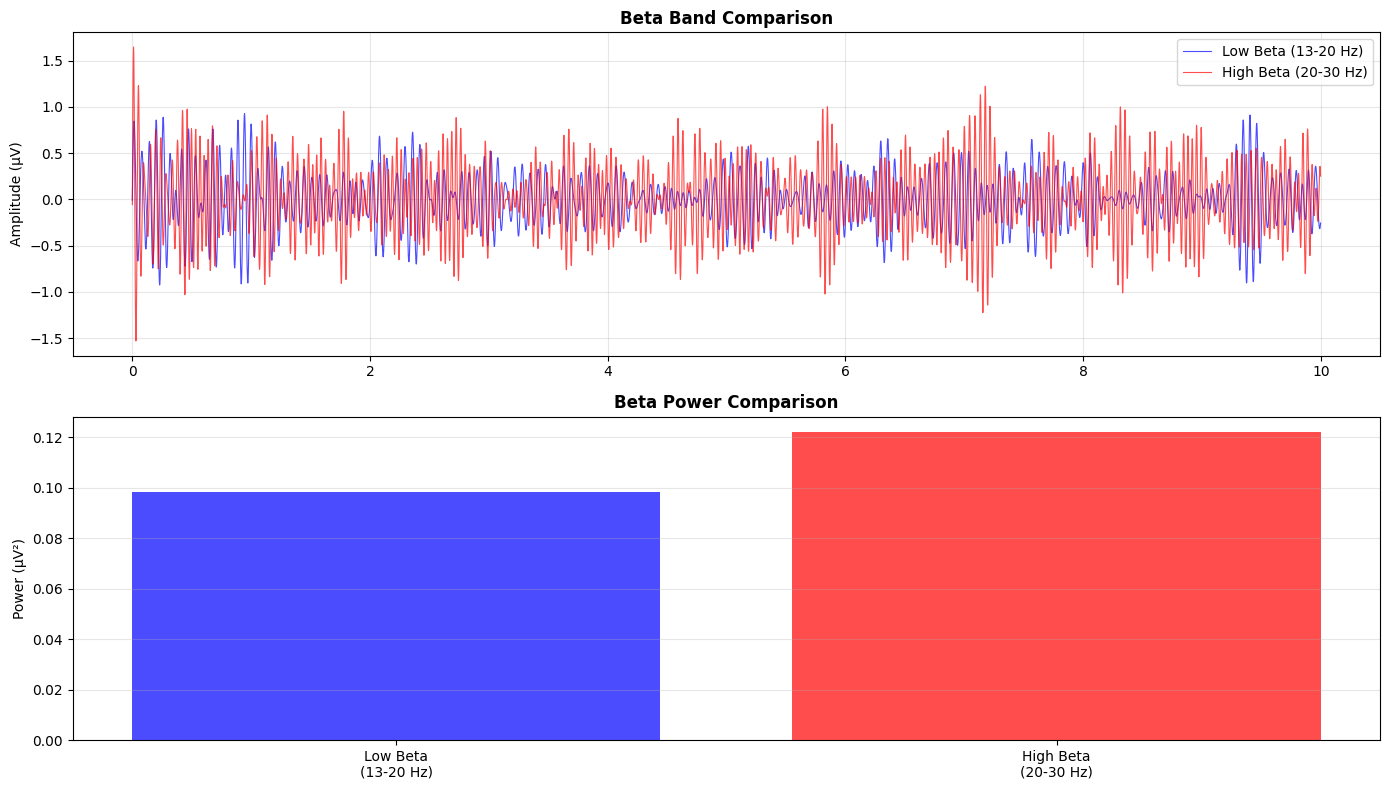


💡 Interpretation:
Your Beta Ratio: 1.24
  → NORMAL: Balanced focus and alertness

📝 Notes:
  - Low Beta: Focused attention, problem solving
  - High Beta: Anxiety, stress, intense concentration


In [29]:
# Extract beta bands
low_beta = bandpass_filter(eeg_preprocessed, 13.0, 20.0, SAMPLING_RATE)
high_beta = bandpass_filter(eeg_preprocessed, 20.0, 30.0, SAMPLING_RATE)

# Calculate power
low_beta_power = np.mean(low_beta ** 2)
high_beta_power = np.mean(high_beta ** 2)
beta_ratio = high_beta_power / low_beta_power if low_beta_power > 0 else 0

print(f"\n🧠 Beta Wave Analysis")
print(f"Low Beta Power (13-20 Hz): {low_beta_power:.2f} µV²")
print(f"High Beta Power (20-30 Hz): {high_beta_power:.2f} µV²")
print(f"Beta Ratio (High/Low): {beta_ratio:.2f}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot beta signals
plot_samples = int(10 * SAMPLING_RATE)
axes[0].plot(time[:plot_samples], low_beta[:plot_samples], 'b-', 
             linewidth=0.8, alpha=0.7, label='Low Beta (13-20 Hz)')
axes[0].plot(time[:plot_samples], high_beta[:plot_samples], 'r-', 
             linewidth=0.8, alpha=0.7, label='High Beta (20-30 Hz)')
axes[0].set_title('Beta Band Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude (µV)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Power comparison bar chart
bands = ['Low Beta\n(13-20 Hz)', 'High Beta\n(20-30 Hz)']
powers = [low_beta_power, high_beta_power]
colors = ['blue', 'red']
axes[1].bar(bands, powers, color=colors, alpha=0.7)
axes[1].set_title('Beta Power Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Power (µV²)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print(f"Your Beta Ratio: {beta_ratio:.2f}")
if beta_ratio > 1.5:
    print("  → HIGH: Possible stress or high arousal")
elif beta_ratio > 0.5:
    print("  → NORMAL: Balanced focus and alertness")
else:
    print("  → LOW: Relaxed but focused state")
print("\n📝 Notes:")
print("  - Low Beta: Focused attention, problem solving")
print("  - High Beta: Anxiety, stress, intense concentration")

## Summary

**Key Takeaways:**
- Raw EEG needs preprocessing (highpass → lowpass → notch)
- Delta band excluded due to artifacts
- Relative power (%) better than absolute
- Copy filter and analysis functions for your projects
- Alpha waves indicate relaxation (8-13 Hz)
- Beta waves indicate active thinking (13-30 Hz)
- Burst detection reveals mental state changes

**To adapt for your data:**
1. Change `CSV_FILE`, `CHANNEL_NAME`, `SAMPLING_RATE` in Step 1
2. Adjust `NOTCH_FREQ` (50 Hz Europe/Asia, 60 Hz Americas)
3. Run all cells!